In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# Loading all the transferdata into a dictionary of the top 5 leagues.

In [3]:
WORK_DIR = os.getcwd()
data_folder = os.path.join(WORK_DIR, "data_euro")

# Big five leagues to sort transferdata from
leagues = ['english_premier_league', 'french_ligue_1', 'italian_serie_a', 'spanish_primera_division', 'german_bundesliga_1']

transfer_df = pd.DataFrame()

# Perhaps create a function for this procedure to avoid cluttering

for folder in tqdm(os.listdir(data_folder)):
    temp_path = os.path.join(data_folder, folder)
    
    for league in leagues:
        file_path = os.path.join(temp_path, (league+str('.csv')))
        
        temp_df = pd.read_csv(file_path)

        # Removing nans and 0s in transfer-fees
        temp_df = temp_df[temp_df['fee_cleaned'].notna()]
        temp_df = temp_df[temp_df['fee_cleaned']>0]

        #league_column = pd.DataFrame({'league' : [league for i in range(len(transfer_df))]})
        transfer_df = pd.concat([transfer_df, temp_df])


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 12.64it/s]


# Cleaning the data



In [4]:
# Resetting index
transfer_df = transfer_df.reset_index().drop(columns='index')

# Removing duplicates
transfer_df = transfer_df[~transfer_df.duplicated()]
transfer_df.head()

# Remaking transfer_period (summer/winter) into month (januray/august), denoted by 01/09.
transfer_df.insert(10, "Month", [1 for row in range(len(transfer_df))])
summer_mask = transfer_df["transfer_period"] == "Summer"
transfer_df.loc[summer_mask, "Month"] = 8 # Use this instead of chained indexing 

# Removing the season column
transfer_df = transfer_df.drop(columns = ["transfer_period", "season"])
transfer_df.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,Month,year
0,Middlesbrough FC,Tommy Wright,26.0,Left Winger,Leicester,€910Th.,in,0.91,Premier League,8,1992
1,Middlesbrough FC,Jonathan Gittens,28.0,defence,Southampton,€250Th.,in,0.25,Premier League,8,1992
2,Middlesbrough FC,Stuart Ripley,24.0,Right Winger,Blackburn,€2.00m,out,2.00,Premier League,8,1992
3,Norwich City,Mark Robins,22.0,Centre-Forward,Man Utd,€1.00m,in,1.00,Premier League,8,1992
4,Norwich City,Tim Sherwood,23.0,Central Midfield,Blackburn,€750Th.,out,0.75,Premier League,8,1992


# Adjusting for inflation

In [5]:
# Inflation data from https://www.inflationtool.com/euro/1992-to-present-value?amount=1&year2=2022&frequency=yearly
CPI = pd.read_csv("euro_inflation.csv", sep=";")

# Calculating inverted change in inflation
CPI["Change"] = CPI.loc[len(CPI)-1, "Value"]/CPI["Value"]

# Dropping column and setting index
CPI = CPI.drop(columns=['Value'])
CPI = CPI.set_index("Period")

# Creating dictionary 
inflation = CPI.to_dict()["Change"]

In [6]:
# Creating inflation adjusted fees
df = transfer_df
df.insert(8,"fee_infladj", np.zeros(len(df)))

# Add ignore error here

for year in range(1991,2022):
    year_mask = df["year"] == year
    df.loc[year_mask, "fee_infladj"] = inflation[year]*df.loc[year_mask,"fee_cleaned"]
    #df["fee_infladj"].loc[year_mask] = inflation[year]*df["fee_cleaned"].loc[year_mask]


In [7]:
df = df[df["transfer_movement"]== "in"] #Selecting only in transfers to avoid duplicates

# AdHoc Analysis of Data

## Inflation adjusted transfer fees (in €)

Text(0.5, 1.0, 'Inflation adjusted transfer fees \nBig Five Leagues')

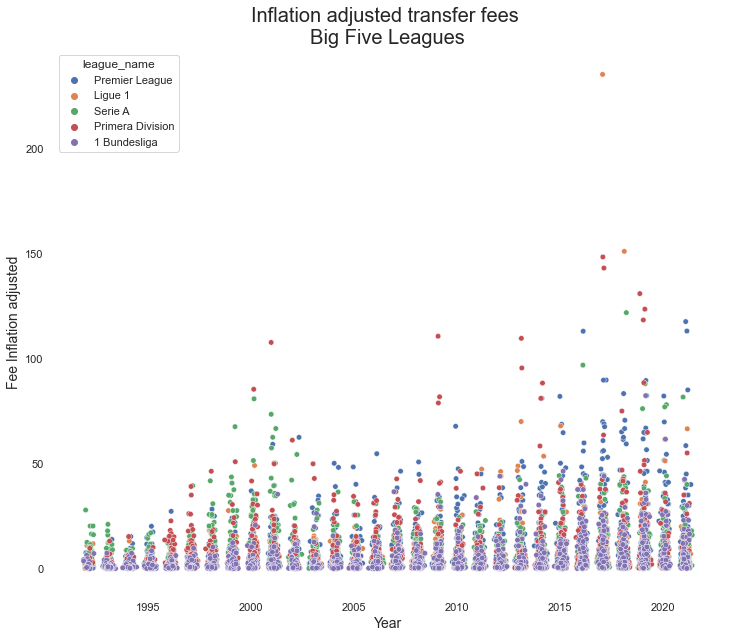

In [8]:
def jitter(values, j):
    return values + np.random.normal(j, 0.1,values.shape)

sns.set(rc={'figure.figsize':(12,10)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

plot1 = sns.scatterplot(
    x = jitter(df.year, 0.1),
    y = df.fee_infladj,
    hue =df.league_name, s=30, alpha=1 )
plot1.set_xlabel("Year", fontsize = 14)
plot1.set_ylabel("Fee Inflation adjusted", fontsize = 14)
plot1.set_title("Inflation adjusted transfer fees \nBig Five Leagues", fontsize=20)

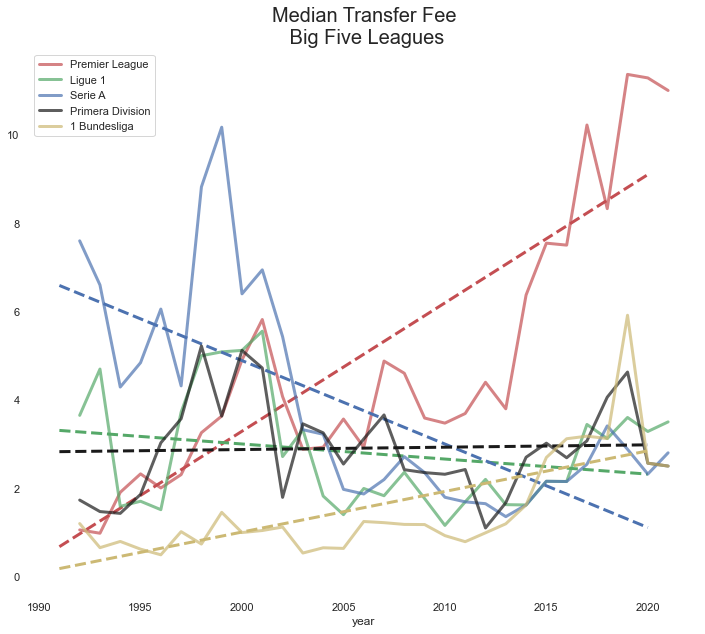

In [9]:
# Median Growth For Each League
median_growth = df.groupby(['league_name', 'year'])['fee_infladj'].median()

from sklearn.linear_model import LinearRegression

league_growth = {}
X = np.arange(1991,2021).reshape(-1,1)

colors = ['r','g','b','k','y']

verbose = False

for i,league in enumerate(df["league_name"].unique()):
    
    # regression of median transfer value vs year
    y = median_growth[league].to_numpy()
    league_growth[league] = LinearRegression().fit(X,y)
    
    # Plotting the median trends
    median_growth[league].plot(label=league,color=colors[i], linewidth=3, alpha=0.7)
    plt.plot(X, league_growth[league].predict(X), linestyle='--',linewidth = 3, 
             #label=league,
             color=colors[i])
    plt.legend()
    
    plt.title("Median Transfer Fee\n Big Five Leagues", fontsize = 20)
    
    if verbose == True:
        # Printing R2 score and regression coefficients for each league
        print("League: " +league + "")
        print("Score= {} ".format(league_growth[league].score(X,y)))
        print("Regression equation : \nMedian = {}x+{} \n".format(league_growth[league].coef_[0],
                                                                league_growth[league].intercept_))

## How is the median correlated with amount of transfers for each season?

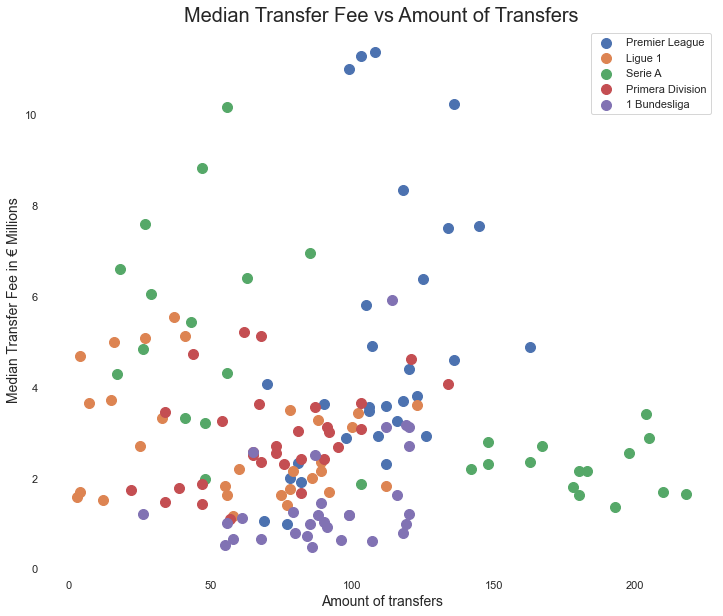

In [10]:
n_transfers = df.groupby(['league_name', 'year'])['fee_infladj'].count()
for league in df["league_name"].unique():
    plt.scatter(n_transfers[league],
                median_growth[league],
                label=league,
                s= 100)
    plt.xlabel("Amount of transfers", fontsize = 14)
    plt.ylabel("Median Transfer Fee in € Millions", fontsize = 14)
    plt.title("Median Transfer Fee vs Amount of Transfers", fontsize=20)
    plt.legend()

## Distribution plot of inflation adjusted transfers

Text(0, 0.5, '% of all transfer purchases')

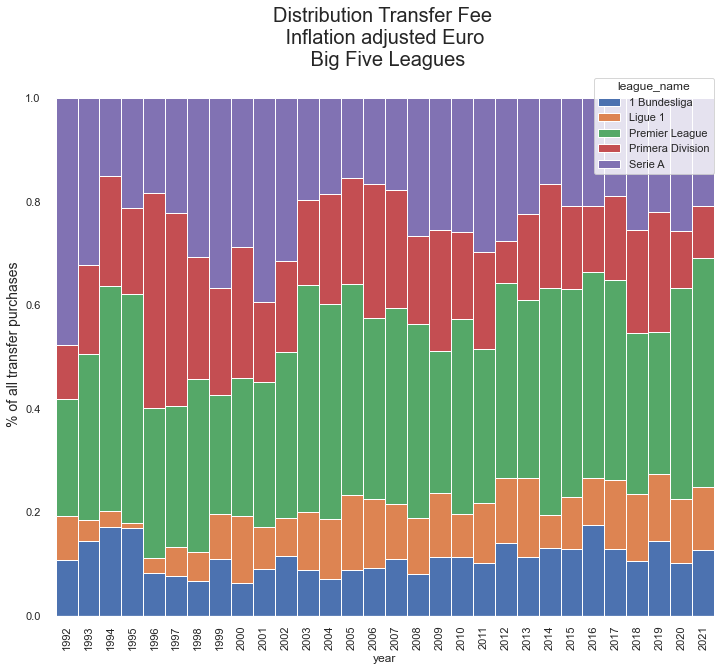

In [18]:
# Cross tab for transfer fees
cross_tab_prop = pd.crosstab(index=df["year"],
                            columns = df["league_name"],
                             values = df["fee_infladj"], aggfunc = 'sum', normalize='index')
cross_tab_prop.plot(kind="bar", stacked=True, width=1)
plt.title("Distribution Transfer Fee \n Inflation adjusted Euro \n Big Five Leagues", fontsize=20)
plt.ylabel("% of all transfer purchases", fontsize=14)

## Scatterplot of transfer fee vs age at transfers

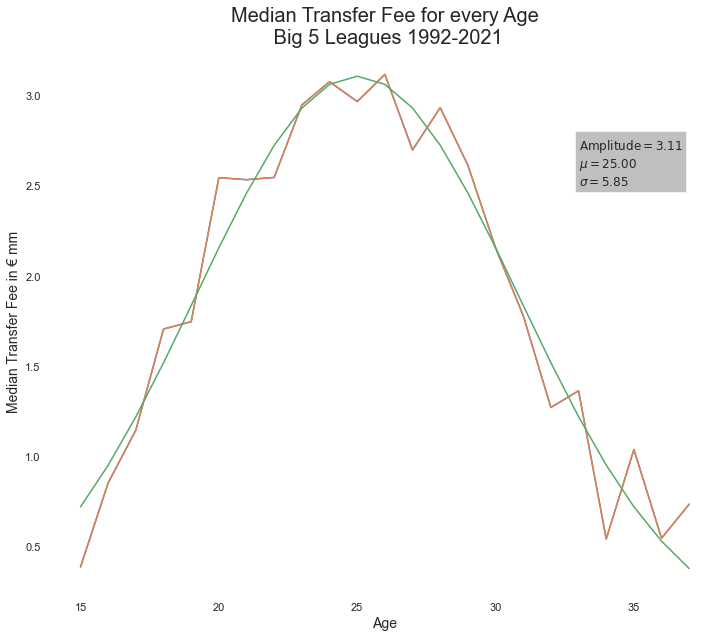

In [284]:
from scipy.optimize import curve_fit
age_fee = df.groupby(["age"])["fee_infladj"].median() 
plt.plot(age_fee)

ages = np.sort(df["age"].dropna().unique())


med_fee = age_fee.to_numpy()

mean = np.mean(ages)
sigma = np.std(ages)

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

parameters, covariance = curve_fit(Gauss, ages, med_fee, p0=[3, mean, sigma])

fit_A, fit_B, fit_C = parameters

med_fee_pred = Gauss(ages, fit_A, fit_B, fit_C)

plt.plot(ages, med_fee)
plt.plot(ages, med_fee_pred)
plt.title("Median Transfer Fee for every Age\n Big 5 Leagues 1992-2021", fontsize=20)
plt.xlabel("Age", fontsize=14)
plt.ylabel("Median Transfer Fee in € mm", fontsize=14)

textstr = '\n'.join((
    r'$\mathrm{Amplitude}=%.2f$' % (fit_A),
    r'$\mu=%.2f$' % (fit_B, ),
    r'$\sigma=%.2f$' % (fit_C, )))


plt.text(33, 2.5, textstr, bbox=dict(facecolor='gray', alpha=0.5))

plt.savefig(fname = "agedecay.png",
           dpi=400)

### But do we first need to adjust for the increase in market share? Football players in the large leagues can be sold for larger sums after the age of 30 due to better nutrition and fitness leaving footballers to play longer! Adjusting for inflation might not be enough alternation of the data to yield an objective observation. Plotting the mean and median ages of footballplayers for each year would give an answer.

Text(0, 0.5, 'Average Age')

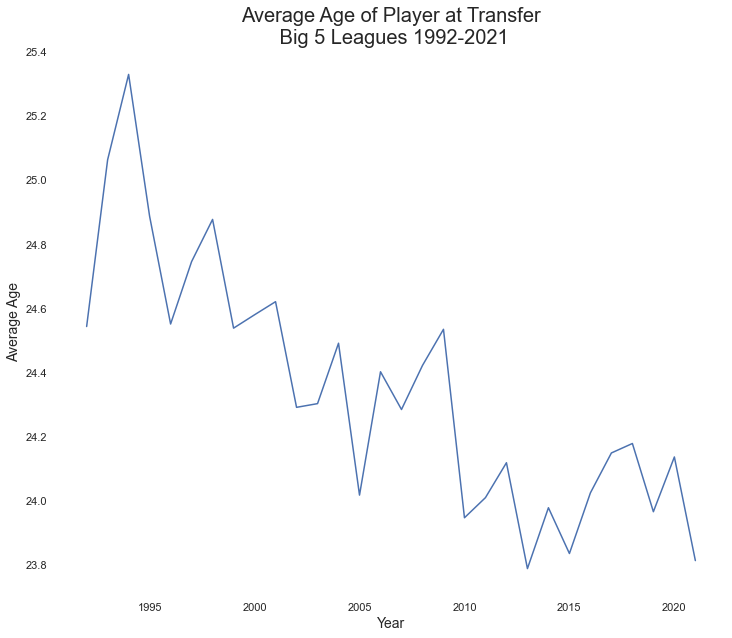

In [22]:
plt.plot(df.groupby(["year"])["age"].mean())
plt.title("Average Age of Player at Transfer\n Big 5 Leagues 1992-2021", fontsize=20)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Age", fontsize=14)

## Average time between transfers (not change of club as contracts can expire)


In [106]:
# Finding duplicates
duplicates = df[df.duplicated(subset="player_name")]
dupe_players = duplicates["player_name"].unique()
m_df = df[df["player_name"].isin(dupe_players)]

# Adding "summer" to the years
m_df.loc[m_df["Month"]==8, "year"] +=0.5
m_df.head(3)

# Grouping every player for access to transfer history
player_df = m_df.groupby("player_name")


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,fee_infladj,league_name,Month,year
3,Norwich City,Mark Robins,22.0,Centre-Forward,Man Utd,€1.00m,in,1.0,1.688446,Premier League,8,1992.5
11,Sheffield Wednesday,Chris Waddle,31.0,Attacking Midfield,Marseille,€1.50m,in,1.5,2.532668,Premier League,8,1992.5
13,Wimbledon FC,Dean Holdsworth,23.0,Centre-Forward,Brentford,€1.00m,in,1.0,1.688446,Premier League,8,1992.5


## Finding out how long between transfer and what the fees for those transfers were

In [176]:
dupe_fee = np.array([])
dupe_time = np.array([])

for dupe in dupe_players:
    temp = player_df.get_group(dupe)
    
    if np.any(temp["year"].diff()[1:].to_numpy() >14):
        print(dupe)
    dupe_time = np.append(dupe_time, np.abs(temp["year"].diff()[1:]).to_numpy()) # time between transfers
    dupe_fee = np.append(dupe_fee, temp["fee_infladj"][1:].to_numpy()) # transfer_fee after the transfer
    
# Many of the player_names are used for multiple players and is therefore non-unique. 
# This flaw is hopefully overshadowed by the "unique" player_names.
# player_df.get_group("Pape Sarr")

Cafú
Juanfran
Lionel Scaloni
Jorginho
Paolo Cannavaro
Pedro
Juanmi
Juan Carlos
Luciano
Matt Clarke
Pape Sarr


Text(0, 0.5, 'Median Transfer Fee (€ MM)')

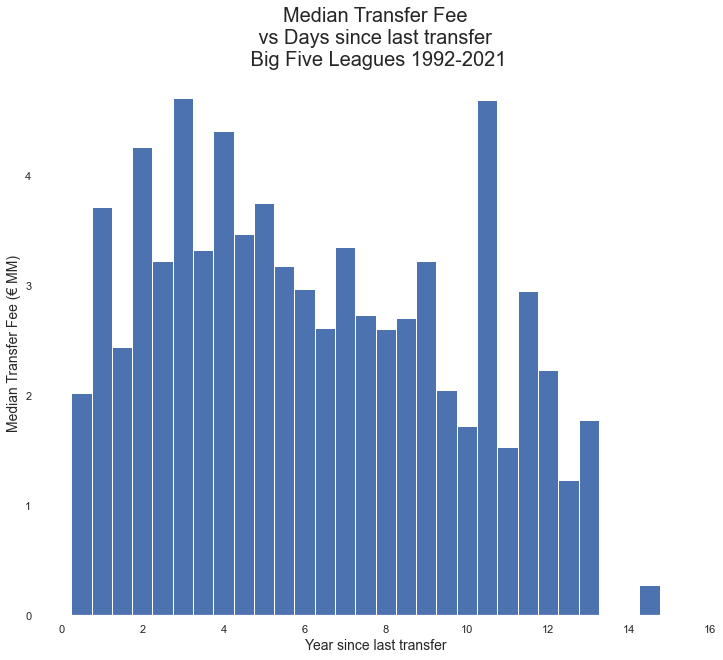

In [285]:
dupe_data = pd.DataFrame(np.concatenate([dupe_time.reshape(-1,1),
                                         dupe_fee.reshape(-1,1)],
                                        axis=1),
                         columns=['transfer_dt', 'transfer_fee'])

dupe_hist = dupe_data.groupby('transfer_dt')['transfer_fee'].median()[:15]

plt.bar(x = dupe_hist.index[1:],
        height = dupe_hist.to_numpy()[1:],#/np.sum(dupe_hist.to_numpy()[1:]),
        width=0.5
       )

plt.title("Median Transfer Fee\n vs Days since last transfer \n Big Five Leagues 1992-2021", fontsize=20)
plt.xlabel("Year since last transfer", fontsize=14)
plt.ylabel("Median Transfer Fee (€ MM)", fontsize=14)

### Florin Raducioiu (see transfermakrt https://www.transfermarkt.com/florin-raducioiu/profil/spieler/16167) is listed as being resold 4 days after he was purchased. This appears to be wrong and should therefore be removed from the data. 
### There can also be players in the data who have been signed to a league not in the dataset, and then signed by a big five league. Need to therefore make sure that the "club_involved_name" is within the top five leagues by making a list of club_name and making sure club_involved_name is within that list.
### However for a player to play within these leagues **i would** think it is likely they are continuing to stay in this level. Therefore the shape of the data should bear some resemblance to what it really should look like.

Text(0.5, 0, 'Years')

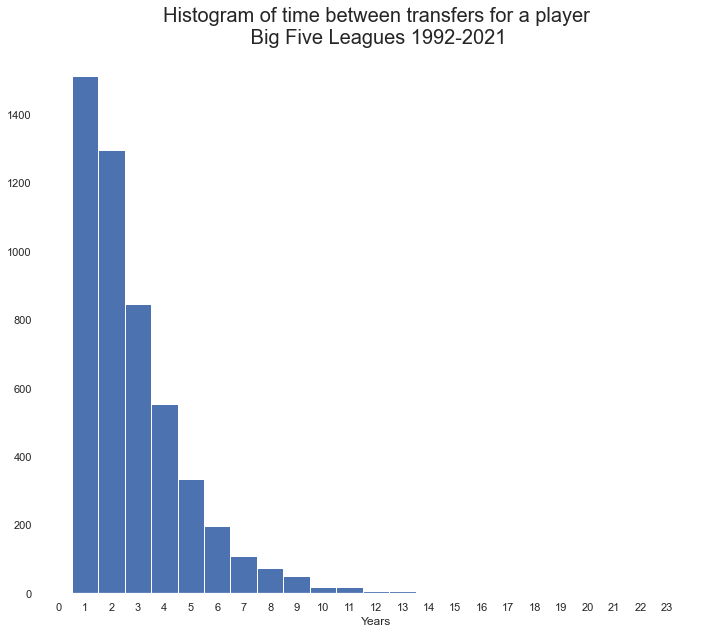

In [217]:
_ = plt.hist(dupe_time, bins=np.arange(0.5,max(delta_transfer+1)))
_ = plt.xticks(np.arange(0,max(delta_transfer+1)))

plt.title("Histogram of time between transfers for a player\n Big Five Leagues 1992-2021", fontsize=20)
plt.xlabel("Years")

In [ ]:
# Weighted skills columns over last 5 seasons?
# Pseudoalg:
#  1 - find playername in skills dataframe
#  2 - add up their 5 last seasons stats
#  3 - Add the weighted skills to the "transfer_df" dataframe
# Then create a rough model to see how well the stats fit.
# NB: How long did they have left on the contract when they were bought? 
# Check distribution of how long people are in a club before they move!

## Analysis methodology
 The idea for the analysis is to create a model, or equation if you will, from an intuitive stand point to estimate expected transfer fee for a player. 
 The transfer fee will be denoted in 2021 inflation adjusted € Euros and also adjusted for the current median market price for 2021. 
 The intuitive equation for the expected transfer fee looks like
$$ \mathbb{E} [TF] = S\cdot t \cdot e^{-(Y-\mu)/(2\sigma^2)} $$

Where $TF$ is the transfer fee, $S$ is the skill level, $t$ is the time since last contract, $e^{-(Y-\mu)/(2\sigma^2)}$ is the age effect, in where $Y$ is the age, $\mu$ is the average age found to be around $25$ years old, and $\sigma$ is the standard deviation fitted.

## Skill level
The skill level is a set of measurable, on pitch football statistics such as Shot-Creating Actions, Goal-Creating Actions, Tackles-Won, Successulf Pressures, Interceptions. Each position will have its own model and weights.
 There are two ways of portraying this information as a 1-D vector: either show the average of some 5 seasons, or just show the best season before that transfer.

To "squash" all the seasons worth of data into one, a weighted sum is used. To infer how much these weights should be, one would need to evaluate the probability/likelihood of a good season n years in past have of replicating itself in the future. If say Hazard who had a really good season 2018/2019 and subsequently a bad season 2019/2020, how likely is it now he will replicate an equally good season next year? 

Think about this: A player who had a two very good seasons, followed by a very poor one. How likely is it if a club purchased him, that the next season he would have very good metrics? The last season, which weighs the most, will not portray alot about his skill level, but his previous seasons does.

## Contract length

 Ideally, contract length until expiry should be used instead of $t$ time since the last transfer. However contract data seems very hard to come by and is relationship between $t$ and transfer fee will be examined.

## Age Decay
One wants to pay less for very old and very young players, and want to play higher for them if they are around 25 years old (as found in analysis). For median transferfee in all big five leagues since 1992, we can see that that the amplitude $a=3.11$,$ \mu = 25$ and $\sigma = 5.85$. Points varying from this line is then considered to be controlled by contract and skill effect. The age decay, shown in the figure below, is given as 

$$ \Large Ae^{-(Y-\mu)/(2\sigma^2)} $$



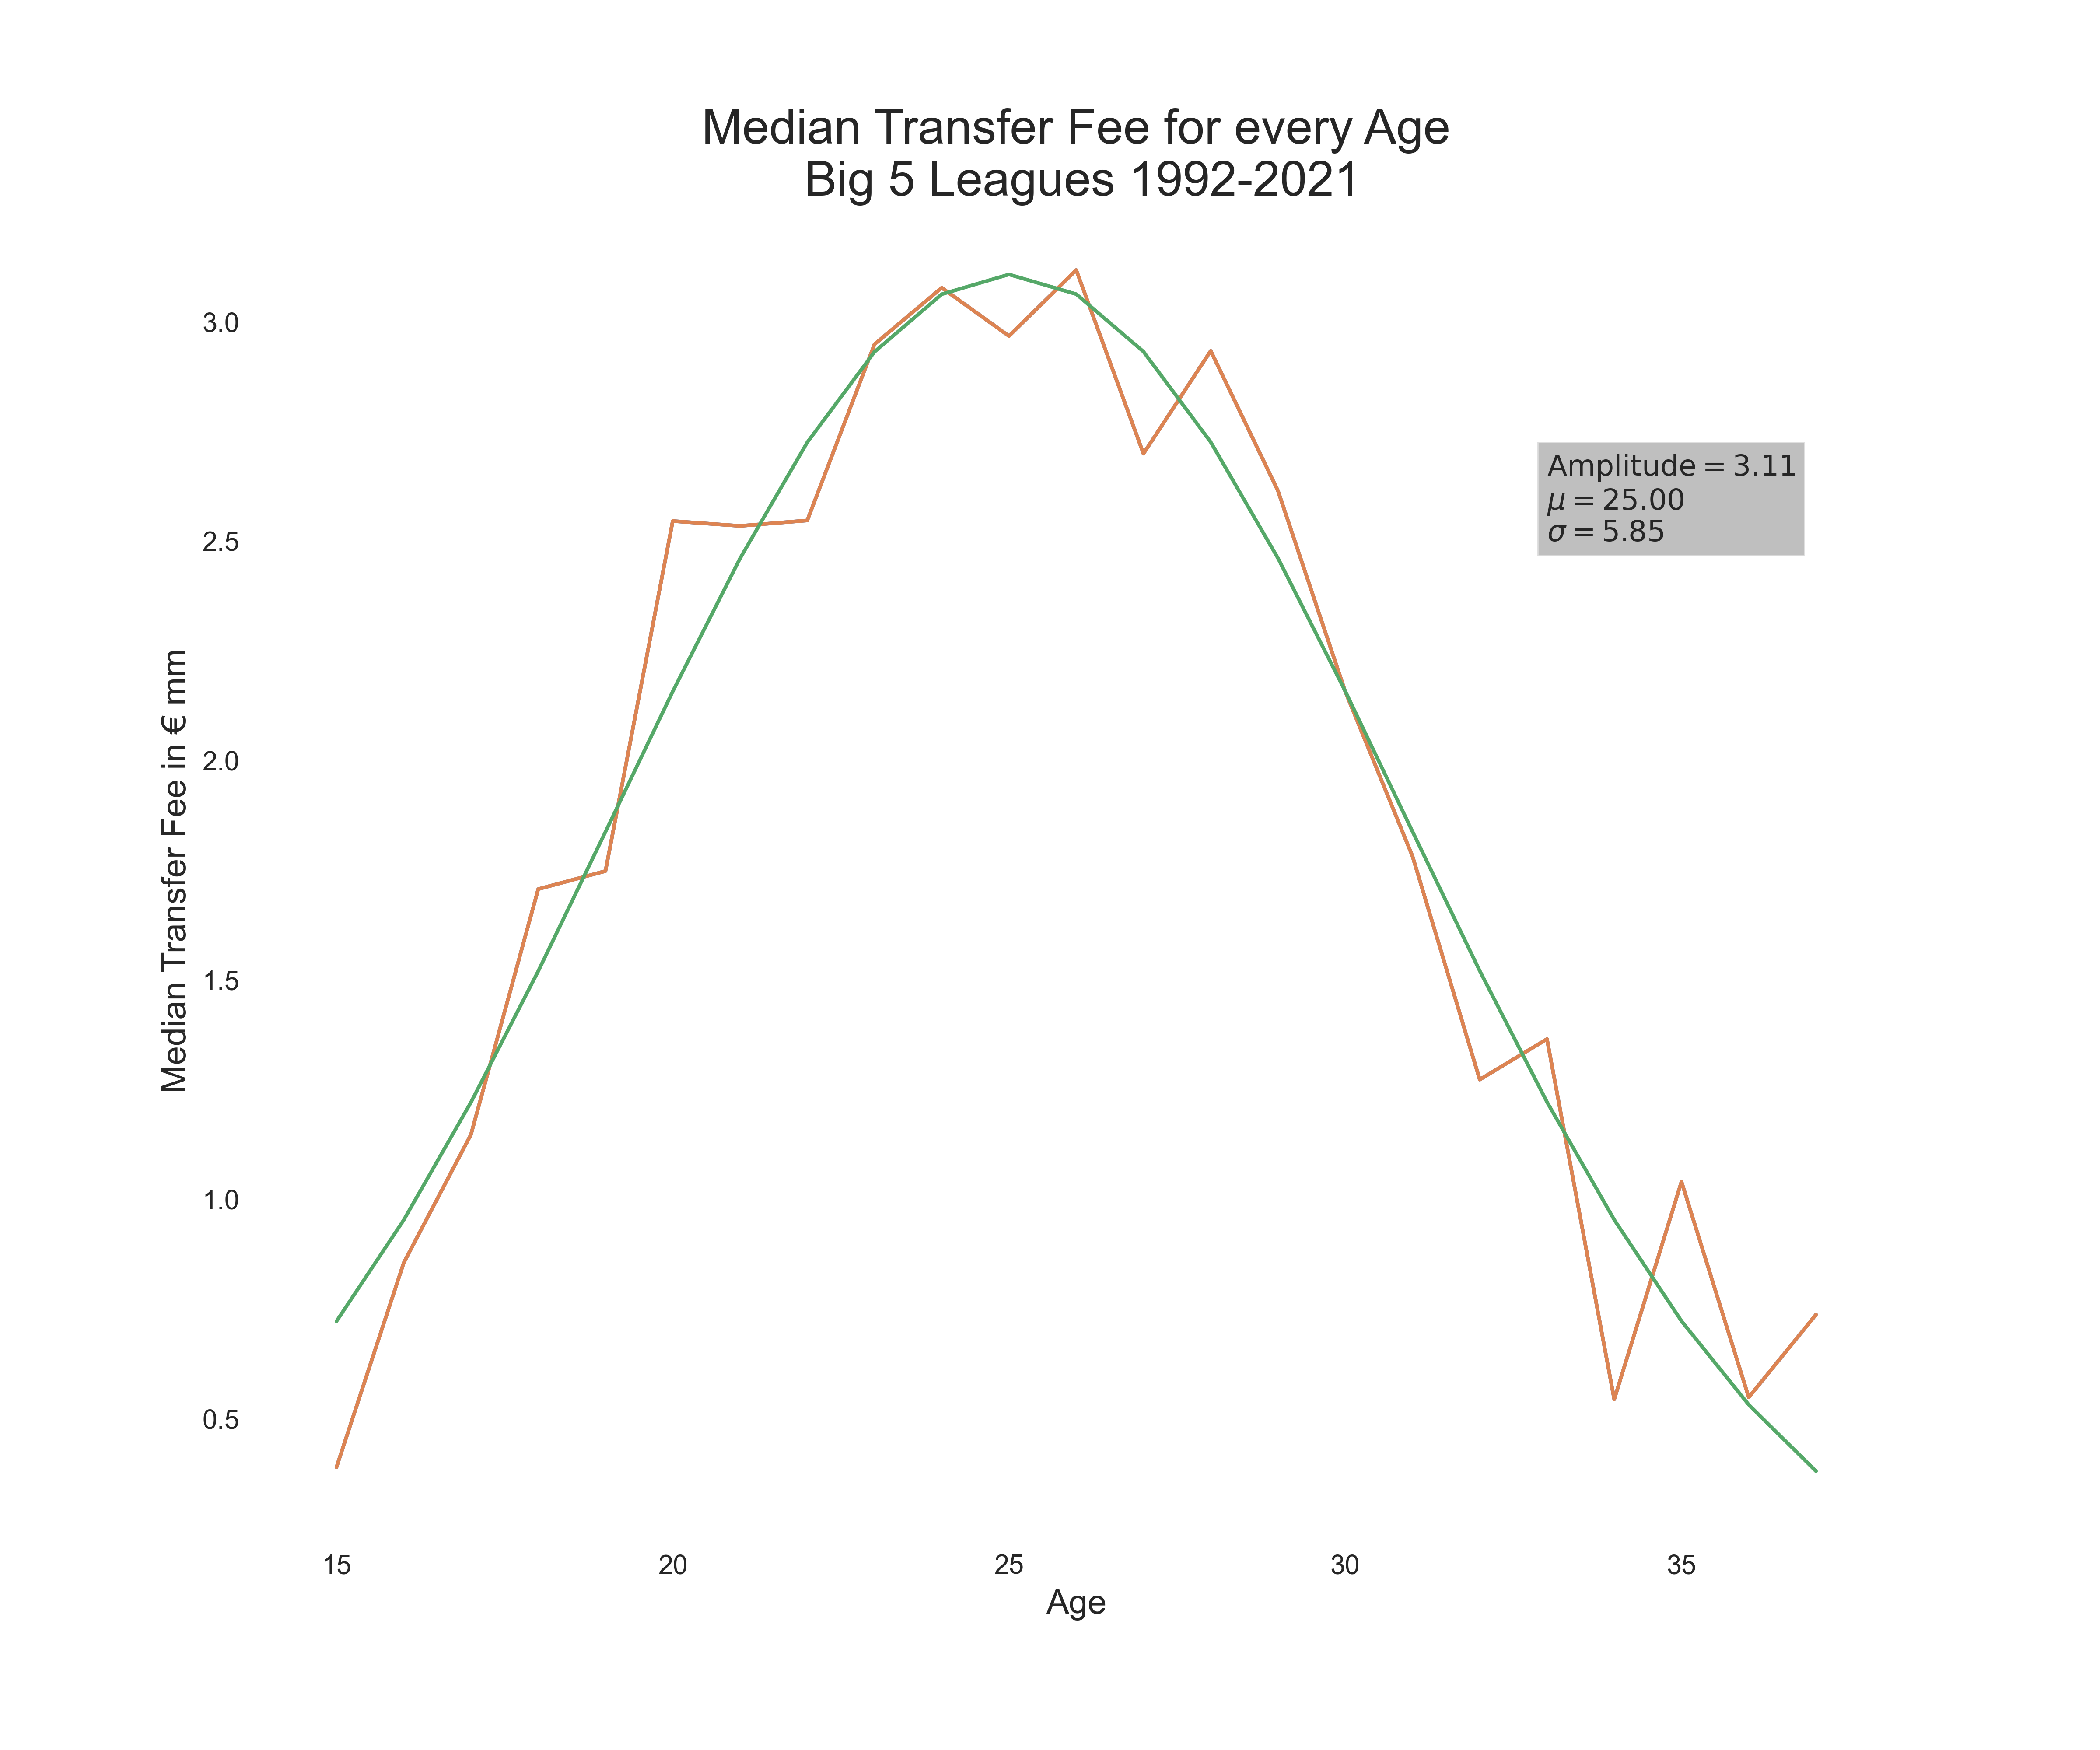


